In [1]:
import pandas as pd
import numpy as np
import os
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import scipy
from sklearn import linear_model, metrics, pipeline, preprocessing
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

fir the y column: 1 = confirmed fraud, 0 = passed OTP (good customer), -1 = unknown status

# To Do
1. drop duplicates from the dummy variables
2. use new data
3. setup dummy variables as dashboard

In [2]:
os.getcwd()

'C:\\Users\\RJP1F47\\Fraud_Project_loca'

In [3]:
#for reading full df
#df = pd.read_csv('omsa_project_cleaned_data.csv')
df = scipy.sparse.load_npz('omsa_project_cleaned_data.npz').tocsr()
y = pd.read_csv('omsa_project_cleaned_labels.csv')

In [4]:
df.shape

(622571, 122762)

In [5]:
y.value_counts()

Final Review Status
-1                     516080
 0                      91695
 1                      14796
dtype: int64

In [6]:
y = y.values.ravel()
pre_pseudo_labels = y.copy()

In [7]:
pre_ssl_labeled = (y != -1).ravel()

## Modeling Setup
-test model on full dataset, will probably do even better

In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import HuberRegressor
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Config Settings

In [9]:
min_change_step = 100
limit_master = 0.95
step_master = 0.05
iterations_max = 100

# Iterative SVM classification

In [10]:
#clf = LinearSVC(dual=False, )
clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup


In [11]:
#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

100
--- 520.7334372997284 seconds ---


#start timer
start_time = time.time()

iterations = 1
limit = 0.95
step = 0.05
y = pre_pseudo_labels.copy()

accuracy = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < 100 and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel()
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < 500:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_isvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
print("--- %s seconds ---" % (time.time() - start_time))

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

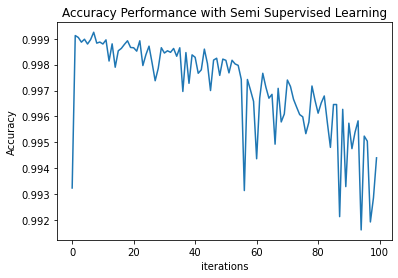

In [12]:
plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [13]:
missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

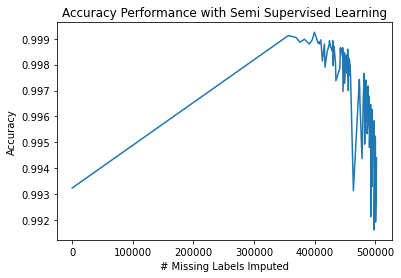

In [14]:
plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [15]:
missing_labels_imputed

array([     0, 356690, 369337, 375560, 383400, 391217, 396353, 399683,
       405906, 407196, 408143, 410237, 412860, 416163, 417125, 421054,
       422469, 423962, 424517, 426461, 427215, 429290, 429926, 430636,
       431374, 432018, 434454, 435138, 441628, 442568, 443131, 443692,
       444227, 445615, 446004, 446369, 446865, 449206, 449583, 451970,
       452290, 453341, 454178, 454626, 455013, 455681, 455984, 456242,
       456458, 456745, 456929, 457054, 457560, 457631, 458651, 459453,
       463985, 473810, 474488, 474781, 478221, 480287, 481878, 482012,
       482125, 482369, 482622, 483429, 483907, 484284, 484551, 484683,
       484743, 485354, 485943, 486257, 486616, 487822, 488213, 488426,
       488905, 489063, 489610, 490072, 490472, 492390, 492533, 492700,
       494769, 494846, 495955, 496263, 497504, 497896, 498227, 500109,
       500349, 500589, 501385, 502183])

In [16]:
pd.DataFrame(pre_pseudo_labels).value_counts()

-1    516080
 0     91695
 1     14796
dtype: int64

In [17]:
pd.DataFrame(y).value_counts()

 0    393364
 1    215310
-1     13897
dtype: int64

In [18]:
#save values
accuracy_isvm = accuracy.copy()
iterations_isvm = iterations
missing_labels_imputed_isvm = missing_labels_imputed.copy()
y_isvm = y.copy()
accuracy_orig_data_isvm = accuracy_orig_data.copy()

# Cluster-then-label (fuzzy c-means & svm approach)
1. visualize clusters with TSNE
2. fuzzy c-means clusters
3. analysis of cluster separability
4. Assign labels
5. SVM and look at accuracy

In [19]:
#conda install fuzzy-c-means

In [20]:
import skfuzzy as fuzz
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

#### Optimizing and utilizing PCA before KMeans

In [21]:
from sklearn.decomposition import TruncatedSVD

In [22]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [23]:
tsvd = TruncatedSVD()
tsvd.fit(df)
optimal_comp = select_n_components(tsvd.explained_variance_ratio_, 0.9999)
print(optimal_comp)

2


In [24]:
tsvd = TruncatedSVD(n_components = optimal_comp)
df_pca = tsvd.fit_transform(df)

In [ ]:
df_pca.shape()

We are going to use a sample to determine the optimal K value here for KMeans

In [25]:
sample = np.random.choice(list(range(0,df.shape[0])), 2000)

In [26]:
from sklearn.cluster import KMeans #https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [27]:
 optimal_k = np.argmin(calculate_WSS(df_pca[sample], 10)) +1 #plus 1 for index starts at 1 as min cluster size

In [28]:
print(optimal_k)

10


Run our clustering now

In [29]:
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

In [30]:
#array of the
df_cluster = kmeans.fit_transform(df_pca)

In [31]:
df_cluster.shape

(622571, 10)

In [32]:
#for this model we are changing the X we use. 
df_orig = df.copy()
df = df_cluster.copy()
del df_cluster, df_pca

use our new clustering df to run svm classifier

In [33]:
#resetup since we are using warm_start
clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup

In [34]:
#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

38
--- 438.0026593208313 seconds ---


In [35]:
#return to normal
df = df_orig.copy()

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

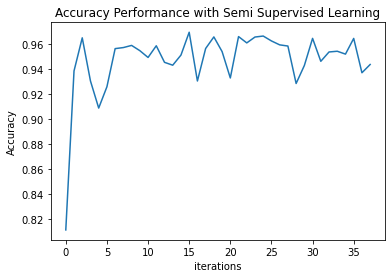

In [36]:
plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [37]:
missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

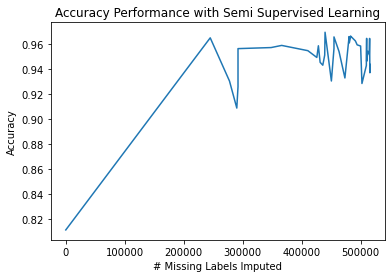

In [38]:
plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [39]:
missing_labels_imputed

array([     0, 202646, 244901, 277541, 289965, 292009, 292009, 348103,
       366055, 410422, 425644, 428297, 431249, 435775, 439019, 439602,
       450335, 454741, 454741, 463332, 473268, 480342, 480683, 482841,
       482841, 491053, 494040, 499915, 502161, 509629, 510103, 510112,
       512313, 512342, 514551, 515161, 515595, 516080])

In [40]:
pd.DataFrame(pre_pseudo_labels).value_counts()

-1    516080
 0     91695
 1     14796
dtype: int64

In [41]:
pd.DataFrame(y).value_counts()

0    487236
1    135335
dtype: int64

In [42]:
#save values
accuracy_csvm = accuracy.copy()
iterations_csvm = iterations
missing_labels_imputed_csvm = missing_labels_imputed.copy()
y_csvm = y.copy()
accuracy_orig_data_csvm = accuracy_orig_data.copy()

# KNN Label Propagation (Previously TSVM) 

In [43]:
#ONLY IF WE HAVE TIME!!!

In [44]:
#can't accept a sparse X matrix
#from sklearn.semi_supervised import LabelPropagation
#clf = LabelPropagation(kernel = 'knn')

In [45]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
#NN =  MLPClassifier(random_state=1, warm_start=True)
#clf = SelfTrainingClassifier(NN)
#clf = MLPClassifier(random_state=1, warm_start=True)
#clf=MLPClassifier(random_state=1,warm_start=True, hidden_layer_sizes = (50,), max_iter=50, n_iter_no_change=3)

In [46]:
#reset y
#y = pre_pseudo_labels.copy()
#run model, -1 labels are considered "unlabeled"
#clf.fit(df, y)

#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

missing_labels_imputed

pd.DataFrame(pre_pseudo_labels).value_counts()

pd.DataFrame(y).value_counts()

#save values
accuracy_lp = accuracy.copy()
iterations_lp = iterations
missing_labels_imputed_lp = missing_labels_imputed.copy()
y_lp = y.copy()
accuracy_orig_data_lp = accuracy_orig_data.copy()

### Self Training Classifier True Version

In [47]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
#NN =  MLPClassifier(random_state=1, warm_start=True)
NN = clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup
clf = SelfTrainingClassifier(NN)
y = pre_pseudo_labels.copy()
clf.fit(df, y)
y_stc = clf.predict(df)
accuracy_stc = (accuracy_score(y[pre_ssl_labeled], y_stc[pre_ssl_labeled]))
iteration_labeled = clf.labeled_iter_


In [48]:
print(accuracy_stc)

0.9954644054427134


In [49]:
probs_stc = clf.predict_proba(df)

# Analysis

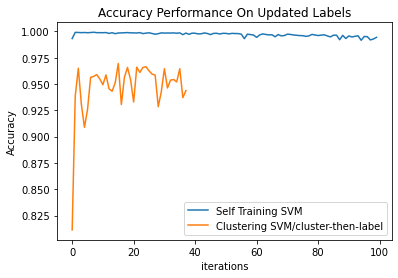

In [50]:
plt.plot(range(0,iterations_isvm), accuracy_isvm, label = 'Self Training SVM')
plt.plot(range(0,iterations_csvm), accuracy_csvm, label = 'Clustering SVM/cluster-then-label')
#plt.plot(range(0,iterations_lp), accuracy_lp, label = 'KNN Label Propagation')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Updated Labels')
plt.legend()
plt.show()

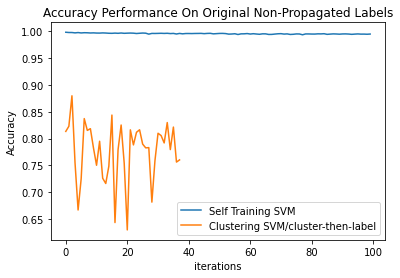

In [51]:
plt.plot(range(0,iterations_isvm), accuracy_orig_data_isvm, label = 'Self Training SVM')
plt.plot(range(0,iterations_csvm), accuracy_orig_data_csvm, label = 'Clustering SVM/cluster-then-label')
#plt.plot(range(0,iterations_lp), accuracy_orig_data_lp, label = 'KNN Label Propagation')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Original Non-Propagated Labels')
plt.legend()
plt.show()

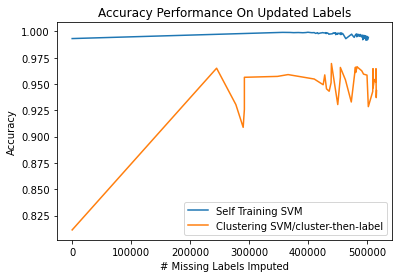

In [52]:
plt.plot(missing_labels_imputed_isvm, accuracy_isvm, label = 'Self Training SVM')
plt.plot(missing_labels_imputed_csvm, accuracy_csvm, label = 'Clustering SVM/cluster-then-label')
#plt.plot(missing_labels_imputed_lp, accuracy_lp, label = 'KNN Label Propagation')
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Updated Labels')
plt.legend()
plt.show()

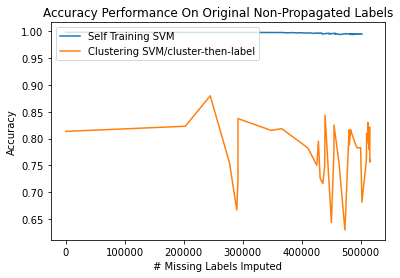

In [53]:
plt.plot(missing_labels_imputed_isvm, accuracy_orig_data_isvm, label = 'Self Training SVM')
plt.plot(missing_labels_imputed_csvm, accuracy_orig_data_csvm, label = 'Clustering SVM/cluster-then-label')
#plt.plot(missing_labels_imputed_lp, accuracy_orig_data_lp, label = 'KNN Label Propagation')
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Original Non-Propagated Labels')
plt.legend()
plt.show()

In [54]:
#Absolute Difference in predicted probability across the different models
abs_diff_probabilities_models = np.zeros((3,3))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_lp]):
    for ji, j in enumerate([probs_isvm, probs_csvm, probs_stc]):
        abs_diff_probabilities_models[ii,ji] = abs(i - j).sum()

print(abs_diff_probabilities_models)

NameError: name 'probs_isvm' is not defined

In [ ]:
#Sum of Squared Difference in Probabilities across classes
ssd_classes_and_models = np.zeros((3,1))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_stc]):
        ssd_classes_and_models[ii] = ((i[:,0] - i[:,1])**2).sum()

print(ssd_classes_and_models)

In [ ]:
#Mean Probability of classes
median_probability_classes = np.zeros((3,2))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_stc]):
        median_probability_classes[ii,0] = np.median(i[:,0])
        median_probability_classes[ii,1] = np.median(i[:,1])

print(median_probability_classes)